In [1]:
# %load_ext rpy2.ipython
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster
from sklearn import decomposition, mixture
from scipy.stats import ttest_ind
from clustergram import Clustergram
from sklearn.model_selection import train_test_split
import warnings
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import decomposition
import numpy.linalg as la
warnings.filterwarnings('ignore')

# Part 1

## Data Pre-processing

Reading in files.

In [2]:
control = pd.read_csv('Control_Data.csv') 
exposed = pd.read_csv('Exposed_Data.csv')
data_dictionary = pd.read_csv('data_dictionary.csv')
exposed['exposed'] = 1
control['exposed'] = 0
df = pd.concat([exposed, control], ignore_index = True)

Data cleaning

In [33]:
cat = df.columns[df.dtypes=='object']
df = pd.get_dummies(df, columns=cat) # change categorical into dummy variables
factors = ['zip11', 'cbsa_code', 'census_tract', 'census_block_id', 'census_block_group', 'msa'] #Removing redundant features-- these are all correlated with each other.
df = df.drop(columns = factors) 
df = df.drop(columns=['gender_U']) 

In [ ]:
df.dropna(axis='columns', thresh= 1600) #drop columns with too many NA
# Find the fill rate of each Individual blu ID (row)
df['Fill_Rate'] = df.sum(axis = 1) / df.shape[1]
indexNames_low_fill_ind = df[df['Fill_Rate'] < .70].index
# Deleting Individuals (rows) from data frame with low fill rates.
df.drop(indexNames_low_fill_ind, inplace=True)
#fill missing values
df.drop(columns = ['Fill_Rate'], inplace=True)

In [31]:
# Filter out binary dummy variables from the DataFrame to get only numeric variables, fill missing values
dummy_mask = df.apply(lambda col: set(col.unique()) == {0, 1})
non_dummy_columns = df.columns[~dummy_mask]
filtered_data = df[non_dummy_columns]
median_values = df[non_dummy_columns].median()
df[non_dummy_columns] = df[non_dummy_columns].fillna(median_values)
df_control = df.loc[df['exposed'] == 0,]
df_exposed = df.loc[df['exposed'] == 1,]
df.isna().sum()

gender                                     0
income                                     0
contributor_index                          0
credit_card                                0
credit_cards_regular_visa_or_mastercard    0
                                          ..
chh01                                      0
chh04                                      0
poc                                        0
prpty169                                   0
exposed                                    0
Length: 454, dtype: int64

## Demographics of the samples

Age and Income

age
exposed_Mean: 51.345382
exposed_Median: 52.000000
control_Mean: 53.486294
control_Median: 54.000000

income
exposed_Mean: 72504.115226
exposed_Median: 62000.000000
control_Mean: 75236.536431
control_Median: 52000.000000



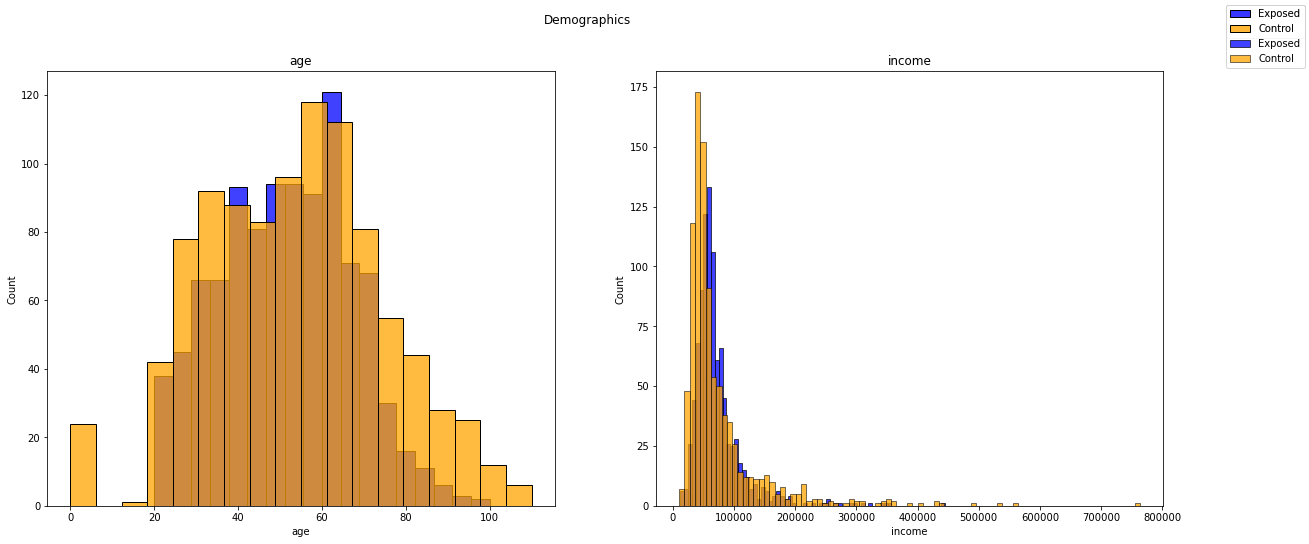

In [28]:
num = ['age', 'income']
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Demographics')

# Plot
for i in range(len(num)):
    axes[i].set_title(num[i])
    sns.histplot(exposed[num[i]], ax=axes[i], color="blue", label="Exposed")
    sns.histplot(control[num[i]], ax=axes[i], color="orange", label="Control")
    fig.legend()
    print(num[i])
    print("exposed_Mean: %f" % exposed[num[i]].mean())
    print("exposed_Median: %f" % exposed[num[i]].median())
    print("control_Mean: %f" % control[num[i]].mean())
    print("control_Median: %f" % control[num[i]].median())
    print()


Education

In [29]:
labs = {'edu100': 'Education_HighSchool', 
        'edu101': 'Education_SomeCollege', 
        'edu102': 'Education_CollegeGrad',
        'edu103': 'Education_MastersGrad'}
df = df.rename(columns = labs)
edu_list = [i for i in labs.values()]
education = df.groupby('exposed')[edu_list].sum()
education

,Education_HighSchool,Education_SomeCollege,Education_CollegeGrad,Education_MastersGrad
exposed,,,,
0,127,119,37,10
1,210,205,72,9


Gender

In [34]:
gender_list = ['gender_M', 'gender_F', 'gender_I']
gender = df.groupby('exposed')[gender_list].sum()
gender

,gender_M,gender_F,gender_I
exposed,,,
0,463,474,40
1,294,655,37


### Comparing means to find largest differences between the exposed and control group

In [44]:
def find_variables_with_largest_differences(dataset1, dataset2, num_top_variables=10):
    # Step 2: Calculate Differences
    differences = {}
    for column in dataset1.columns:
        if dataset1[column].nunique() == 2 and dataset2[column].nunique() == 2:
            proportion_dataset1 = dataset1[column].mean()
            proportion_dataset2 = dataset2[column].mean()
            absolute_difference = abs(proportion_dataset1 - proportion_dataset2)
            differences[column] = {
                'dataset1_mean': proportion_dataset1,
                'dataset2_mean': proportion_dataset2,
                'absolute_difference': absolute_difference
            }

    # Step 3: Sort and Select Top Variables
    sorted_differences = sorted(differences.items(), key=lambda x: x[1]['absolute_difference'], reverse=True)
    top_variables = [item[0] for item in sorted_differences[:num_top_variables]]
    top_variables_info = {item[0]: item[1] for item in sorted_differences[:num_top_variables]}

    return top_variables, top_variables_info

What are the top attributes that make the Treatment Group different from the Control group?

In [45]:
num_top_variables = 10
top_variables, top_variables_info = find_variables_with_largest_differences(df_control, df_exposed, num_top_variables)
# attributes = list(dictionary['attribute_name'].str.lower())
# Print the comparison for the top variables

for variable in top_variables:
    print(f"Attribute Name:" {data_dictionary[variable]['attribute_name']}")
    print(f"Control Mean: {top_variables_info[variable]['dataset1_mean']:.3f}")
    print(f"Exposed Mean: {top_variables_info[variable]['dataset2_mean']:.3f}")
    print(f"Absolute Difference: {top_variables_info[variable]['absolute_difference']:.3f}")
    print()

SyntaxError: invalid syntax (3195899524.py, line 7)

### Conducting factor analysis to reduce dimensions before clustering.

In [43]:
# Standardize all variables except dummy variables.
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(df[non_dummy_columns])
## Set the data to a matrix
TD = np.array(data_scaled)

KeyError: "['gender', 'family_position', 'investment_type', 'marital_status', 'net_worth', 'political_affiliation', 'cbsa_code', 'census_tract', 'census_block_group', 'congress_dist', 'county_name', 'msa', 'state', 'urbanicity', 'census_block_id', 'county_code', 'zip11'] not in index"

In [42]:
pca = decomposition.PCA() ## create the function
XTrans = pca.fit_transform(data_scaled) ## apply PCA on data set
print(pca.explained_variance_ratio_) ## get the percent explained for each PC

NameError: name 'data_scaled' is not defined

#### Examining the Explained Variance Ratio 

In [46]:
# Displaying the individual contribution of each component
plt.plot((pca.explained_variance_ratio_[0:10]))
plt.xlabel('number of components')
plt.ylabel("Individual Components' explained variance")
plt.show()

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [47]:
# Displaying the combined contribution of the components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [ ]:
# choose the number of components you would like to include: 
numDimensions = 8
pct_of_data_explained = round(sum(pca.explained_variance_ratio_[0:numDimensions]),2)*100
print(f"Having {numDimensions} components will explain {pct_of_data_explained}% of the data") 

In [ ]:
#Create New Dataframe
loadings = XTrans[:,:(7)]
loadings = pd.DataFrame(loadings)

We are looking to segment the Treatment and Control groups using their attributes. Using Cluster analysis:
- Recommend the appropriate number of clusters: 2 (treatment and control group).
- Explain the similarity measure you applied: Ward
- Interpret, describe, and validate the cluster

I'll use the loadings from the factor analysis to do cluster analysis.

In [48]:
# this will show you the differences between clusters 
# and how much of the data is in each cluster
cgram = Clustergram(range(1, 10))
cgram.fit(loadings)
cgram.plot()

NameError: name 'loadings' is not defined

In [ ]:
Z = linkage(loadings, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [ ]:
# Choose a threshold (height) for cutting the tree to get the desired number of clusters
num_clusters = 2
clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
loadings['cluster'] = clusters

Validating Cluster Performance

In [49]:
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(exposed, clusters)

print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-measure:", v_measure)

NameError: name 'homogeneity_completeness_v_measure' is not defined

# Part 2

In this part of the assignment you are free to use any statistical technique that can help you explain the outcome / response metric from the Treatment group compared to the Control group. You can use logistic regression, propensity score analysis and matching and/or any other technique. The response metric from the Treatment Group is an “Email SignUp”.

In [51]:
# Create Train and Test data 
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['exposed']),df['exposed'],test_size=0.25,random_state=0) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape,y_train.sum(),y_test.sum()
X_train_sample = X_train
X_test_sample = X_test

y_train_sample = y_train
y_test_sample = y_test

In [ ]:
############# LogReg
LRclf = LogisticRegression(solver = 'newton-cg', class_weight = 'auto')
LRclf.fit(X_train_sample, y_train_sample)

In [ ]:
############# Random Forest
RFclf = RandomForestClassifier(class_weight='balanced_subsample')
RFclf.fit(X_train_sample, y_train_sample)

In [ ]:
# Feature Importance
rf_features = RFclf.feature_importances_
cols = X_train_sample.columns.values

# Create a dataframe with features
rf_features_dataframe = pd.DataFrame( {'features': cols,
     'RF feature importances': rf_features})
rf_features_dataframe = rf_features_dataframe.sort_values('RF feature importances', ascending=False)
rf_features_dataframe = rf_features_dataframe[:30]
rf_features_dataframe.plot.bar(x='features', y='RF feature importances', figsize=(10,6))

In [ ]:
lr_features = [i * -1 if i < 0 else i for i in lr_features]
cols = X_train.columns.values
# Create a dataframe with features
features_dataframe = pd.DataFrame( {'LR feature importances' :lr_features,
                                    'RF feature importances': rf_features,
                                   })

features_dataframe.set_index(cols, drop=True, inplace=True, verify_integrity=True)
fet_vars = [var for var in features_dataframe.columns ]

# create scaler
scaler = MinMaxScaler(feature_range=(1, 100))
#  fit  the scaler to the train set
scaler.fit(features_dataframe[fet_vars]) 
# transform the train and test set
features_dataframe[fet_vars] = scaler.transform(features_dataframe[fet_vars])

What are the variables explaining the differences between the Treatment and the Control group?

In [ ]:
features_dataframe.T.mean().sort_values(ascending=False)[:37].to_csv('key_features_email_signup.csv')
key_features = features_dataframe.T.mean().sort_values(ascending=False)[:37]
key_features=key_features.drop(index=[])
features_dataframe = features_dataframe.T[key_features.index]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(features_dataframe.columns, features_dataframe.mean())

Did you train your model? Explain - Yes, I trained the logistic regression model to improve classification.

In [ ]:
predtrn=LRclf.predict_proba(X_train)[:,1]
y_test_predict=LRclf.predict_proba(X_test)[:,1]
features_dataframe.T.mean().sort_values(ascending=False)[:25]
y_train_pred = np.where(predtrn >= 0.006, 1, 0)
y_test_pred = np.where(y_test_predict >= 0.006, 1, 0)
cm_train = confusion_matrix(y_train_sample, y_train_pred)
cm_test = confusion_matrix(y_test_sample, y_test_pred)

In [ ]:
# AUC Score
roc_auc_score(y_test_sample, y_test_predict),roc_auc_score(y_train_sample, predtrn)

In [ ]:
print(cm_train)
print(cm_test)
print('Train Accuracy' + str(accuracy_score(y_train, y_train_pred)))
print('Test Accuracy' + str(accuracy_score(y_test, y_test_pred)))

<i> Did you get inconclusive results? Was the quality of the data a factor in the inconclusive results? Explain potential reasons the results of your model are inconclusive and/or statistically significant? </i>

I received statistically significant results. However, there were data issues that limited the reliability of the modeling results. For example, I was modeling off of the raw data which had a lot of multicollinearity and a lot of missing values. 